In [260]:
%load_ext autoreload
%autoreload 2

In [259]:
PROJECT_PATH = '../'
import sys
sys.path.insert(0, PROJECT_PATH)

In [13]:
import matplotlib.pyplot as plt


In [1]:
from tensorflow.keras.layers import Input, Dense, Add, Activation
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import random

In [2]:
from tensorflow import keras

In [7]:
print(tf.version.VERSION)

2.7.0


In [43]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255, x_test / 255
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [44]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

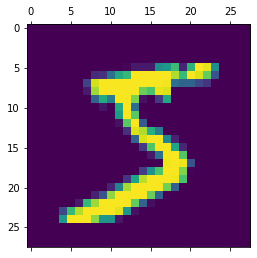

In [45]:
plt.matshow(x_train[0])

In [60]:
from tensorflow.keras import layers as la

In [139]:
x = np.array([[10000,1000,100,10,1,0.1,0.01,0.001],[0,0,0,0,0,0,0,0]])
stddev = np.array([[1,2,3,4,5,6,7,8],[8,7,6,5,4,3,2,1]])

In [226]:
def get_var(ssm, skym, step=1):
    #--------------------------------------------
    # Get the total variance
    # BETA is the scaling for the sky
    # VREAD is the variance of the white noise
    # This variance is still scaled with an additional
    # factor when we simuate an observation.
    #--------------------------------------------
    BETA  = 10.0
    VREAD = 16000
    varm  = ssm + BETA*skym + VREAD
    if step <= 1: 
        return varm
    else:
        return np.divide(varm, step)

In [249]:
def get_var_fn(ssm):
    return (ssm)

In [252]:
class NoiseAugLayer(tf.keras.layers.Layer):
    def __init__(self, get_var_fn, stddev_len, noise_level=0):
        super(NoiseAugLayer, self).__init__()
        self.get_var_fn = get_var_fn
        self.num_outputs = stddev_len
        self.noise_level = noise_level

    def get_noise(self, stddev):
        print(stddev)
        noise = tf.random.normal(shape=(1,self.num_outputs), mean=0, stddev=stddev, seed=42)
        return noise
        
    def call(self, inputs):
        var = self.get_var_fn(inputs)
        stddev = tf.math.sqrt(var)
        if self.noise_level > 0: stddev = stddev * self.noise_level
        noise = self.get_noise(stddev)
        return inputs + noise

In [253]:
y = tf.zeros((2,8))

In [257]:
NoiseAugLayer(get_var_fn, 8, noise_level=0)(x)

tf.Tensor(
[[1.0000000e+02 3.1622774e+01 1.0000000e+01 3.1622777e+00 9.9999994e-01
  3.1622776e-01 9.9999994e-02 3.1622779e-02]
 [9.9999994e-01 9.9999994e-01 9.9999994e-01 9.9999994e-01 9.9999994e-01
  9.9999994e-01 9.9999994e-01 9.9999994e-01]], shape=(2, 8), dtype=float32)


<tf.Tensor: shape=(2, 8), dtype=float32, numpy=
array([[ 1.00442100e+04,  1.01657166e+03,  1.12094330e+02,
         9.78683281e+00, -5.45990467e-02,  6.53164148e-01,
         6.23591095e-02,  1.39722470e-02],
       [ 1.44209790e+00,  1.52404249e+00,  2.20943308e+00,
         9.32590723e-01, -5.45990467e-02,  2.74925852e+00,
         1.52359104e+00,  1.41021848e+00]], dtype=float32)>

In [221]:
x

array([[1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03],
       [1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00]])

In [222]:
n(y, x)

[[1.e+04 1.e+03 1.e+02 1.e+01 1.e+00 1.e-01 1.e-02 1.e-03]
 [1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00]]


<tf.Tensor: shape=(2, 8), dtype=float32, numpy=
array([[ 1.5784944e+04, -6.2857202e+02, -9.1982880e+01, -4.7250600e+00,
         1.9498870e-01,  5.5451661e-02,  1.4403284e-02, -4.1224173e-04],
       [ 1.5784944e+00, -6.2857205e-01, -9.1982877e-01, -4.7250599e-01,
         1.9498870e-01,  5.5451661e-01,  1.4403284e+00, -4.1224170e-01]],
      dtype=float32)>

In [363]:
from PIML.nn.dnn.model.noisednn import NoiseDNN

In [364]:
dnn = NoiseDNN()

In [365]:
dnn.set_model_shape(8,8)
dnn.set_model_param()
dnn.build_model(noise_level=1)

Layers: [8, 64, 32, 16, 8]


In [366]:
dnn.model(x)

<tf.Tensor: shape=(2, 8), dtype=float32, numpy=
array([[1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03],
       [1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00]],
      dtype=float32)>

In [368]:
dnn.model([x,x], training=1)

ValueError: Layer "dnn" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor: shape=(2, 8), dtype=float64, numpy=
array([[1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03],
       [1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00]])>, <tf.Tensor: shape=(2, 8), dtype=float64, numpy=
array([[1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03],
       [1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00]])>]

In [349]:
dnn.fit(tf.ones((5,8)), tf.ones((5,8)), tf.ones((5,8)),ep=1)

1/1 - 0s - loss: 1.0000 - mean_squared_error: 1.0000 - val_loss: 1.0000 - val_mean_squared_error: 1.0000 - lr: 0.0100 - 207ms/epoch - 207ms/step


In [350]:
test = [x, x] 

In [351]:
test

[array([[1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03],
        [1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00]]),
 array([[1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03],
        [1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00]])]

In [353]:
dnn.predict(x)

ValueError: in user code:

    File "/datascope/slurm/miniconda3/envs/viska-tf25/lib/python3.9/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/datascope/slurm/miniconda3/envs/viska-tf25/lib/python3.9/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/datascope/slurm/miniconda3/envs/viska-tf25/lib/python3.9/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/datascope/slurm/miniconda3/envs/viska-tf25/lib/python3.9/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/datascope/slurm/miniconda3/envs/viska-tf25/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/datascope/slurm/miniconda3/envs/viska-tf25/lib/python3.9/site-packages/keras/engine/input_spec.py", line 199, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "noisednn" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 8) dtype=float32>]


In [340]:
tf.math.reduce_mean(dnn.predict(test),axis=0)

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([ 4.3075479e+03,  7.3713654e+02,  9.2653328e+01,  3.7551074e+00,
       -1.3172760e+00,  4.3599543e-01,  1.1225126e+00,  9.9876809e-01],
      dtype=float32)>

In [341]:
N=10000
tf.math.reduce_mean(dnn.predict([tf.ones((N,8)), tf.ones((N,8)) * x[0]]),axis=0)

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-513.76776  ,  -18.725481 ,   12.130399 ,    1.1860629,
          1.0272634,    1.0075421,    1.0008882,    1.0000339],
      dtype=float32)>

In [305]:
x[0]

array([1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03])

In [284]:
dnn.model(x)

tf.Tensor(
[[1.0000000e+02 3.1622774e+01 1.0000000e+01 3.1622777e+00 9.9999994e-01
  3.1622776e-01 9.9999994e-02 3.1622779e-02]
 [9.9999994e-01 9.9999994e-01 9.9999994e-01 9.9999994e-01 9.9999994e-01
  9.9999994e-01 9.9999994e-01 9.9999994e-01]], shape=(2, 8), dtype=float32)


<tf.Tensor: shape=(2, 8), dtype=float32, numpy=
array([[ 9.98134375e+03,  1.00688141e+03,  1.01489197e+02,
         1.02374735e+01,  2.28545904e+00, -3.59408036e-02,
         4.36909944e-02,  4.18244302e-02],
       [ 8.13440681e-01,  1.21760893e+00,  1.14891970e+00,
         1.07509565e+00,  2.28545904e+00,  5.70117474e-01,
         1.33691001e+00,  2.29098177e+00]], dtype=float32)>

In [281]:
dnn.model(tf.ones((1,8)))

tf.Tensor(
[[0.99999994 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994
  0.99999994 0.99999994]], shape=(1, 8), dtype=float32)


<tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[ 0.8614235 ,  1.4728003 ,  1.8347193 ,  0.6827468 , -1.3172758 ,
         0.79271895,  2.222797  ,  1.9955406 ]], dtype=float32)>

In [243]:
m0 = tf.keras.Sequential([
    NoiseAugLayer(get_std_fn, 8, )    
    # la.GaussianNoise(1, seed=42)  
])
class MyCustomCallback(tf.keras.callbacks.Callback):
    super
    def on_epoch_begin(self, epoch, logs=None):
        
        print('updating sttdev in training')
        print(self.model.layers[0].stddev)
cc = MyCustomCallback()
m0.compile('adam','mse')
m0.fit(tf.ones((1,8)), tf.ones((1,8)), callbacks=[])
# m0(x, training=True, callbacks=[])

Tensor("Placeholder:0", shape=(None, 8), dtype=float32)
Tensor("IteratorGetNext:0", shape=(None, 8), dtype=float32)
Tensor("IteratorGetNext:0", shape=(None, 8), dtype=float32)
1/1 [==============================] - 0s 116ms/step - loss: 0.6756


In [244]:
y = np.zeros((1000,2,8))

In [246]:
tf.math.reduce_mean(m0(x, training=1), axis=0)

tf.Tensor(
[[1.e+04 1.e+03 1.e+02 1.e+01 1.e+00 1.e-01 1.e-02 1.e-03]
 [1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00]], shape=(2, 8), dtype=float32)


<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([ 6.9576602e+03,  2.4036745e+02,  9.8155556e+01,  1.1980403e+01,
        9.5243239e-01, -3.5262975e-01, -2.1772380e-01, -3.3088619e-01],
      dtype=float32)>

In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):

    def on_epoch_begin(self, epoch, logs=None):
        self.model.layers[2].stddev = random.uniform(0, 1)
        print('updating sttdev in training')
        print(self.model.layers[2].stddev)


X_train = np.zeros((10,100))
y_train = np.zeros((10,10))

noise_change = MyCustomCallback()
model.fit(x_train, 
          y_train, 
          batch_size=32, 
          epochs=5, 
          callbacks = [noise_change])

In [58]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.GaussianNoise(0.5),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

In [59]:
# inputs = Input(shape=100)
# # bn0 = BatchNormalization(axis=1, scale=True)(inputs)
# g0 = GaussianNoise(0.5)(bn0) 
# d0 = Dense(10)(g0)
# model = Model(inputs, d0)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):

    def on_epoch_begin(self, epoch, logs=None):
        self.model.layers[2].stddev = random.uniform(0, 1)
        print('updating sttdev in training')
        print(self.model.layers[2].stddev)

In [50]:
model.fit(x_train, y_train, batch_size=128, epochs=5)

Epoch 1/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0471 - sparse_categorical_accuracy: 0.9862
Epoch 2/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0394 - sparse_categorical_accuracy: 0.9892
Epoch 3/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0348 - sparse_categorical_accuracy: 0.9905
Epoch 4/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0315 - sparse_categorical_accuracy: 0.9915
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0279 - sparse_categorical_accuracy: 0.9925


In [51]:
score = model.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 0s 848us/step - loss: 0.0647 - sparse_categorical_accuracy: 0.9798


In [54]:
model.layers[2].stddev

AttributeError: 'Dense' object has no attribute 'stddev'

In [24]:
class MyCustomCallback(tf.keras.callbacks.Callback):

    def on_epoch_begin(self, epoch, logs=None):
        self.model.layers[2].stddev = random.uniform(0, 1)
        print('updating sttdev in training')
        print(self.model.layers[2].stddev)


X_train = np.zeros((10,100))
y_train = np.zeros((10,10))

noise_change = MyCustomCallback()
model.fit(x_train, 
          y_train, 
          batch_size=32, 
          epochs=5, 
          callbacks = [noise_change])

ValueError: Data cardinality is ambiguous:
  x sizes: 60000
  y sizes: 10
Make sure all arrays contain the same number of samples.